  <h1 style="color: brown;">1. Introduction</h1>

<div style="background-color: #F5F5DC; border: 2px solid #8b4513; padding: 15px; border-radius: 10px; font-family: Arial, sans-serif; box-shadow: 3px 3px 15px rgba(0, 0, 0, 0.1);">

  <p>The XOR classification problem is a classic example in the field of artificial intelligence that highlights the limitations of simple linear models. A multilayer perceptron (MLP) is commonly employed to solve this problem, as it possesses the capability to model non-linear relationships due to the hidden layers and activation functions.</p>

  <p>In this task, the goal is to investigate how the classification performance of an MLP is affected by varying levels of noise in the training data. The XOR dataset is generated with continuous-valued data, where noise is added to the binary inputs (0's and 1's) using a normal distribution. The standard deviation of the noise is systematically increased from 0.1 to 0.5 in increments of 0.1 to evaluate its impact on the classification accuracy of both the training and unseen test data.</p>

  <p>The MLP model consists of a single hidden layer with four nodes, and training is conducted over 100 epochs. The model is trained using the Stochastic Gradient Descent (SGD) optimizer with a learning rate of 0.1, and binary cross-entropy with logits (BCEWithLogitsLoss) is used as the loss function. The Tanh activation function is applied to the hidden layer. The training dataset consists of 2,500 samples, while the test dataset includes 500 samples. The effect of increasing noise levels on the classification accuracy of the MLP model is explored in detail.</p>

</div>


  <h1 style="color: brown;">2. Importing Libraries</h1> 

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(88)

  <h1 style="color: brown;">3. XOR Dataset Class Implementation</h1> 

In [2]:
class XOR_Dataset(torch.utils.data.Dataset):
    def __init__(self, size, std):
        super().__init__()
        # Initializing the dataset size and standard deviation for noise
        self.size = size
        self.std = std
        # Generating the continuous XOR dataset with noise
        self.generate_cont_xor()

    def generate_cont_xor(self):
        # Generating random binary data (0s and 1s) for two input features
        self.data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        # Creating XOR labels (1 if sum of inputs is 1, else 0)
        self.label = (self.data.sum(dim=1) == 1).to(torch.float32).unsqueeze(1)
        # Adding Gaussian noise to the data with the specified standard deviation
        self.data += self.std * torch.randn(self.data.shape)

    def __len__(self):
        # Returning the total number of samples in the dataset
        return self.size

    def __getitem__(self, idx):
        # Returning the data sample and label at the specified index
        return self.data[idx], self.label[idx]

  <h1 style="color: brown;">4. XOR Classifier Model Implementation</h1>

In [3]:
class XOR_Classifier(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        # Defining the first linear layer that connects the input layer to the hidden layer
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        # Defining the activation function for the hidden layer, using Tanh to introduce non-linearity
        self.activation = nn.Tanh()
        # Defining the second linear layer that connects the hidden layer to the output layer
        self.linear2 = nn.Linear(num_hidden, num_outputs)
        
    def forward(self, x):
        # Passing the input through the first linear layer
        x = self.linear1(x)
        # Applying the Tanh activation function to the output of the hidden layer
        x = self.activation(x)
        # Passing the result through the second linear layer to produce the final output
        return self.linear2(x)

  <h1 style="color: brown;">5. XOR Classifier Training and Testing</h1> 

In [4]:
def compute_accuracy(loader, model):
    correct = 0
    total = 0
    model.eval()  # Setting the model to evaluation mode to disable dropout or batch norm
    with torch.no_grad():  # Disabling gradient calculations for efficiency
        for data, label in loader:
            output = model(data)  # Forward pass through the model
            predicted = (torch.sigmoid(output) > 0.5).float()  # Applying sigmoid activation and thresholding at 0.5
            total += label.size(0)  # Counting total samples
            correct += (predicted == label).sum().item()  # Counting correct predictions
    return 100 * correct / total  # Returning accuracy as a percentage

def train_and_visualize(std_values):
    results = []  # To store results for each standard deviation
    models = []  # To store trained models for each standard deviation
    for std in std_values:
        # Creating the training and testing datasets with varying noise levels (std)
        train_dataset = XOR_Dataset(size=2500, std=std)
        test_dataset = XOR_Dataset(size=500, std=std)  # smaller dataset for testing
        train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)  # Loading training data in batches
        test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)  # Loading test data

        # Defining the MLP model with 2 inputs, 4 hidden nodes, and 1 output
        model = XOR_Classifier(num_inputs=2, num_hidden=4, num_outputs=1)
        # Using binary cross-entropy loss for classification tasks
        loss_module = nn.BCEWithLogitsLoss()
        # Using stochastic gradient descent (SGD) as the optimizer with a learning rate of 0.1
        optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

        # Training the model for 100 epochs
        model.train()  # Setting the model to training mode
        for epoch in range(100):
            for data, label in train_loader:
                optimizer.zero_grad()  # Resetting gradients before the backward pass
                output = model(data)  # Forward pass through the model
                loss = loss_module(output, label)  # Computing loss
                loss.backward()  # Backward pass to compute gradients
                optimizer.step()  # Updating model parameters

        # Calculating accuracy on both training and test datasets
        train_accuracy = compute_accuracy(train_loader, model)
        test_accuracy = compute_accuracy(test_loader, model)
        results.append((std, train_accuracy, test_accuracy))  # Storing the results
        models.append(model)  # Saving the trained model for visualization

    # Creating a DataFrame to display the results for each noise level (std)
    results_df = pd.DataFrame(results, columns=["Standard Deviation", "Training Accuracy (%)", "Test Accuracy (%)"])
    return results_df, models  # Returning the results and trained models

# Defining the list of standard deviation values to test
std_values = [0.1, 0.2, 0.3, 0.4, 0.5]
results_df, models = train_and_visualize(std_values)  # Training models and collecting results
print(results_df)  # Displaying the results DataFrame

   Standard Deviation  Training Accuracy (%)  Test Accuracy (%)
0                 0.1                 100.00              100.0
1                 0.2                  97.60               97.6
2                 0.3                  88.08               87.4
3                 0.4                  79.28               78.4
4                 0.5                  73.68               72.0


  <h1 style="color: brown;">6. Visualization for XOR Classifier</h1> 

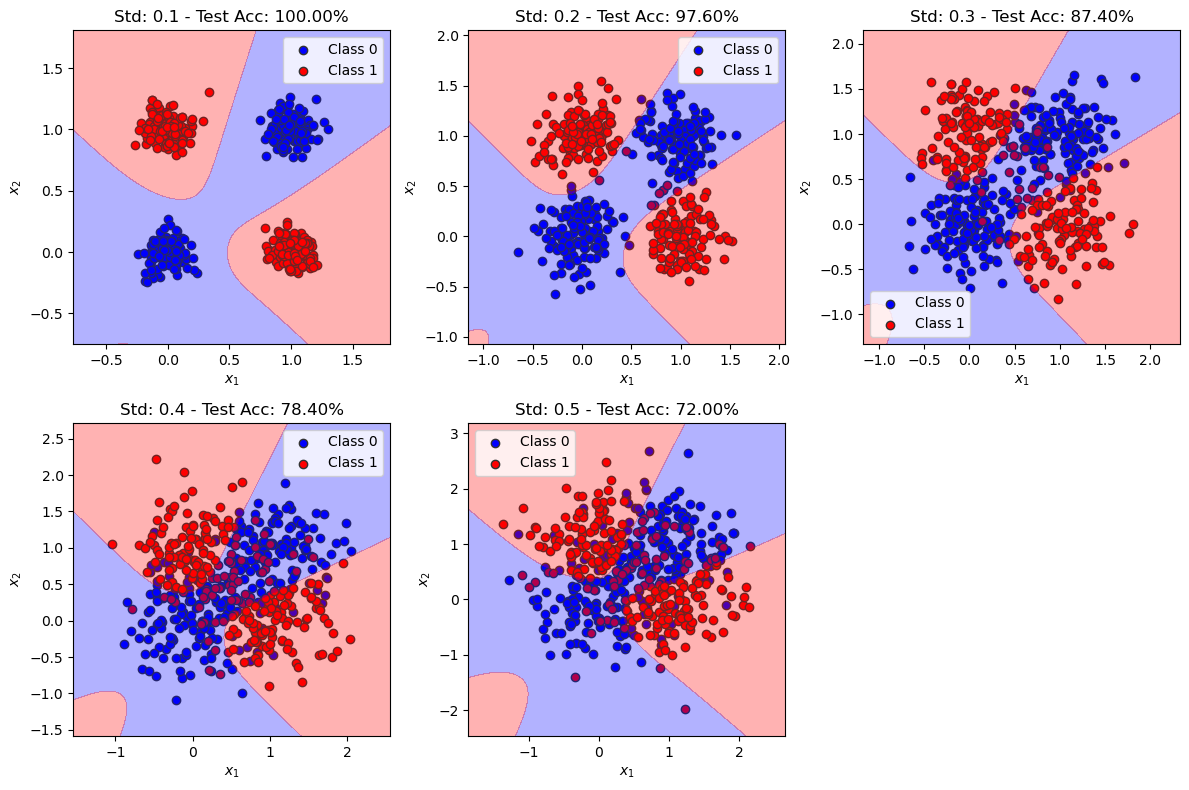

In [11]:
@torch.no_grad()  # Disabling gradient calculations during visualization to save memory
def visualize_classification(model, data, label, ax, std):
    # Separating data into two classes based on label (Class 0 and Class 1)
    data_0 = data[label.squeeze() == 0]  # Data points where the label is 0
    data_1 = data[label.squeeze() == 1]  # Data points where the label is 1
    
    # Plotting Class 0 data points in blue and Class 1 data points in red
    ax.scatter(data_0[:,0].numpy(), data_0[:,1].numpy(), c='blue', edgecolor="#333", label="Class 0")
    ax.scatter(data_1[:,0].numpy(), data_1[:,1].numpy(), c='red', edgecolor="#333", label="Class 1")
    
    # Setting plot title and labels
    ax.set_title(f"Std: {std:.1f} - Test")  # Title showing the standard deviation value
    ax.set_xlabel(r"$x_1$")  # Label for x-axis
    ax.set_ylabel(r"$x_2$")  # Label for y-axis
    ax.legend()  # Adding legend to indicate which color corresponds to which class

    # Defining the boundaries for the decision region visualization
    x_min, x_max = data[:, 0].min() - 0.5, data[:, 0].max() + 0.5
    y_min, y_max = data[:, 1].min() - 0.5, data[:, 1].max() + 0.5
    # Creating a grid of points across the input space
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    # Converting grid points to tensor for model prediction
    mesh = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    
    # Getting model predictions for the grid points
    preds = model(mesh).reshape(xx.shape)
    preds = torch.sigmoid(preds)  # Applying sigmoid to get probabilities

    # Drawing contour plot to show decision boundary between Class 0 and Class 1
    ax.contourf(xx, yy, preds.numpy(), levels=[0, 0.5, 1], colors=['blue', 'red'], alpha=0.3)
    plt.grid(False)  # Disabling the grid for better visualization

# Creating a grid of subplots (3 rows and 2 columns)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # Adjust figure size
axes = axes.flatten()  # Flattening the subplot array for easy indexing

# Iterating through the models and results
for i, (model, (std, train_acc, test_acc)) in enumerate(zip(models, results_df.values)):
    # Generating a new test dataset for the given standard deviation
    test_dataset = XOR_Dataset(size=500, std=std)
    # Visualizing the classification performance of the model
    visualize_classification(model, test_dataset.data, test_dataset.label, axes[i], std)

    # Optionally, update the subplot title to include test accuracy
    axes[i].set_title(f'Std: {std:.1f} - Test Acc: {test_acc:.2f}%')

# Turning off any unused subplots in case there are fewer models than subplots
for ax in axes[len(models):]:
    ax.axis('off')

# Adjusting the layout to prevent overlap between subplots
plt.tight_layout()
plt.show()

  <h1 style="color: brown;">7. Results</h1> 

<div style="background-color: #F5F5DC; border: 2px solid #8b4513; padding: 15px; border-radius: 10px; font-family: Arial, sans-serif; box-shadow: 3px 3px 15px rgba(0, 0, 0, 0.1);">
  
  <p style="font-size: 16px; color: #333;">The table below summarizes the training and test accuracies of the XOR classifier for different levels of noise, as indicated by the standard deviation values.</p>

  <table style="width:100%; border-collapse: collapse; margin: 10px 0; font-size: 16px; color: #333;">
    <tr style="background-color: #8b4513; color: white;">
      <th style="padding: 8px; border: 2px solid black;">Standard Deviation</th>
      <th style="padding: 8px; border: 2px solid black;">Training Accuracy (%)</th>
      <th style="padding: 8px; border: 2px solid black;">Test Accuracy (%)</th>
    </tr>
    <tr>
      <td style="padding: 8px; border: 2px solid black; background-color: #F7F0DB;">0.1</td>
      <td style="padding: 8px; border: 2px solid black; background-color: #F7F0DB;">100.00</td>
      <td style="padding: 8px; border: 2px solid black; background-color: #F7F0DB;">100.0</td>
    </tr>
    <tr>
      <td style="padding: 8px; border: 2px solid black; background-color: #EADAB8;">0.2</td>
      <td style="padding: 8px; border: 2px solid black; background-color: #EADAB8;">97.60</td>
      <td style="padding: 8px; border: 2px solid black; background-color: #EADAB8;">97.6</td>
    </tr>
    <tr>
      <td style="padding: 8px; border: 2px solid black; background-color: #F7F0DB;">0.3</td>
      <td style="padding: 8px; border: 2px solid black; background-color: #F7F0DB;">88.08</td>
      <td style="padding: 8px; border: 2px solid black; background-color: #F7F0DB;">87.4</td>
    </tr>
    <tr>
      <td style="padding: 8px; border: 2px solid black; background-color: #EADAB8;">0.4</td>
      <td style="padding: 8px; border: 2px solid black; background-color: #EADAB8;">79.28</td>
      <td style="padding: 8px; border: 2px solid black; background-color: #EADAB8;">78.4</td>
    </tr>
    <tr>
      <td style="padding: 8px; border: 2px solid black; background-color: #F7F0DB;">0.5</td>
      <td style="padding: 8px; border: 2px solid black; background-color: #F7F0DB;">73.68</td>
      <td style="padding: 8px; border: 2px solid black; background-color: #F7F0DB;">72.0</td>
    </tr>
  </table>

</div>


<h2 style="color: brown;">7.1 Interpretation  of Results</21>

<div style="background-color: #F5F5DC; border: 2px solid #8b4513; padding: 15px; border-radius: 10px; font-family: Arial, sans-serif; box-shadow: 3px 3px 15px rgba(0, 0, 0, 0.1);">

  <p><strong>Noise Impact on Accuracy:</strong></p>
  <p>At the lowest noise level (standard deviation = 0.1), the model achieves perfect accuracy (100%) on both the training and test datasets. This is expected because the data is only slightly perturbed from the original XOR inputs, making the classification task straightforward for the MLP. As the noise level increases, the accuracies of both the training and test datasets gradually decline. This drop is due to the increasing overlap between the classes caused by the noise.</p>

  <p><strong>Training vs. Test Accuracy:</strong></p>
  <p>The training and test accuracies remain closely aligned across different noise levels. The small gap between them suggests that the model is not overfitting, as it generalizes well to unseen test data. This consistency implies that the noise affects both datasets similarly, and the model’s learning capacity remains relatively balanced between the training and test data.</p>

  <p><strong>Significant Drop in Accuracy:</strong></p>
  <p>The most notable drop in accuracy occurs between standard deviations of 0.2 and 0.3. The training accuracy decreases from 97.60% to 88.08%, and test accuracy drops from 97.60% to 87.40%. This drop is due to the fact that, at a standard deviation of 0.3, the noise starts significantly altering the input values, making the XOR pattern harder to detect.</p>

  <p><strong>Model Robustness:</strong></p>
  <p>Despite the increasing noise, the model maintains reasonable accuracy even at the highest noise level of 0.5. With a test accuracy of 72.0%, the MLP still correctly classifies the majority of data points, demonstrating its robustness.</p>

</div>


<h2 style="color: brown;">7.2 Plausible Reasons for Changes in Accuracy</h2> 

<div style="background-color: #F5F5DC; border: 2px solid #8b4513; padding: 15px; border-radius: 10px; font-family: Arial, sans-serif; box-shadow: 3px 3px 15px rgba(0, 0, 0, 0.1);">

  <p><strong>Increased Input Variability:</strong></p>
  <p>As the noise level increases, the variability in the input data rises as well, leading to greater overlap between data points from different classes. This makes it harder for the model to correctly classify the inputs since the XOR classification relies on sharp distinctions between classes.</p>

  <p><strong>Model Capacity vs. Noise:</strong></p>
  <p>The MLP with a single hidden layer and four neurons has limited capacity to capture highly noisy data. While it is effective at solving the XOR problem in low-noise conditions, its capacity is insufficient to fully learn the patterns as noise increases.</p>

  <p><strong>Effect of Noise on Decision Boundaries:</strong></p>
  <p>The introduction of noise blurs the XOR decision boundaries that the model learns. At low noise levels, these boundaries are clear and distinct, allowing the model to perform well. As noise increases, these boundaries become less distinct, resulting in reduced accuracy.</p>

</div>


<h2 style="color: brown;">8. Conclusion</h1>

<div style="background-color: #F5F5DC; border: 2px solid #8b4513; padding: 15px; border-radius: 10px; font-family: Arial, sans-serif; box-shadow: 3px 3px 15px rgba(0, 0, 0, 0.1);">

  <p>The results clearly show that increasing noise in the XOR dataset negatively impacts the MLP classifier's performance. While the model handles low noise levels very well, its performance declines as noise increases. The deterioration in accuracy can be attributed to the increased overlap between classes, the limited capacity of the model, and the blurring of decision boundaries caused by higher noise levels. However, the model demonstrates resilience to moderate noise, maintaining relatively high accuracy even under challenging conditions, thanks to its non-linear capabilities.</p>

</div>
